<a href="https://colab.research.google.com/github/AyorindeTayo/Case-Study-A-Deep-Learning-Knowledge/blob/main/Flowerimageclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing** **Libraries** 




In [50]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


Downloading and Exploration of the Flower datasets

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


To show we have 3670 total image

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Showing some of the Flowers

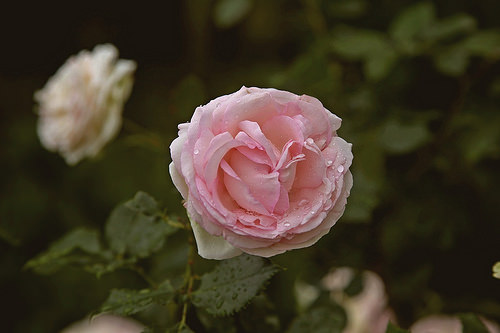

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

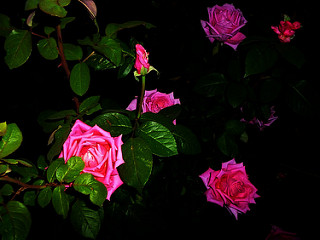

In [5]:
PIL.Image.open(str(roses[1]))

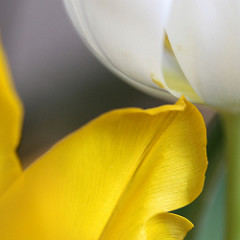

In [6]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

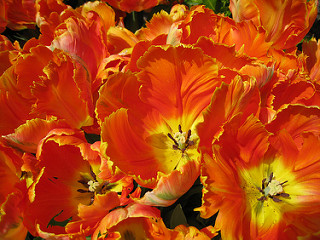

In [7]:
PIL.Image.open(str(tulips[1]))

**Create** **a** **dataset**

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Validation split. 80% Of the images are separated for training and 20% for validation. Thw validation sets is used interchageably as test sets. 

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Finding class names of the flower in the class_names on the datasets, corresponding to the directory names in alphabetical order

In [13]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


**Visualize** **the** **data**

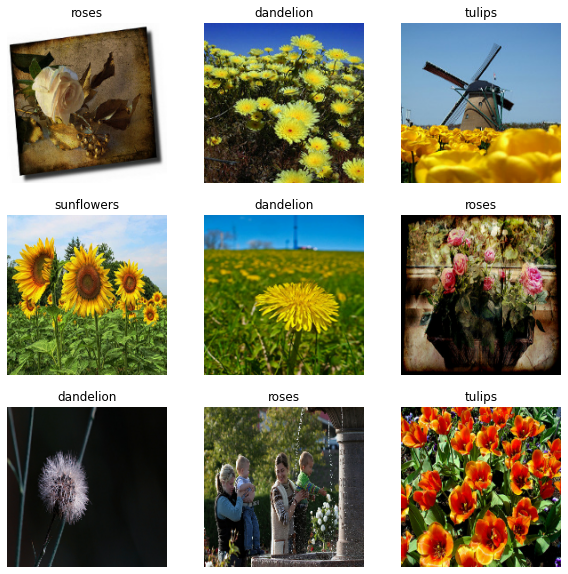

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). The batch 38 images of shape 180x180x3. The last dimmension shows the colors channels RGB. The label_batch is a tensor of the shape (32,), corresponding labels to the 32 images

**To configure** **the** **datasets for** **performance**

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model.





In [18]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardization of the data**
standardize values to be in the [0, 1] range by using a Rescaling layer

1.   The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values to be small

2.   standardize values to be in the [0, 1] range by using a Rescaling layer



In [20]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


**Creating the model**


1.  The model has three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function.







In [24]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compile the model**

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Model** **summary**

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

**Train** **the** **model**

In [27]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 87s 942ms/step - loss: 1.5717 - accuracy: 0.2988 - val_loss: 1.1304 - val_accuracy: 0.5695
Epoch 2/10
92/92 [==============================] - 85s 925ms/step - loss: 1.0419 - accuracy: 0.5810 - val_loss: 0.9793 - val_accuracy: 0.6172
Epoch 3/10
92/92 [==============================] - 85s 925ms/step - loss: 0.8190 - accuracy: 0.6955 - val_loss: 0.8626 - val_accuracy: 0.6649
Epoch 4/10
92/92 [==============================] - 85s 927ms/step - loss: 0.5893 - accuracy: 0.7856 - val_loss: 0.9655 - val_accuracy: 0.6240
Epoch 5/10
92/92 [==============================] - 85s 929ms/step - loss: 0.3897 - accuracy: 0.8698 - val_loss: 0.9691 - val_accuracy: 0.6744
Epoch 6/10
92/92 [==============================] - 86s 932ms/step - loss: 0.2185 - accuracy: 0.9302 - val_loss: 1.1746 - val_accuracy: 0.6362
Epoch 7/10
92/92 [==============================] - 85s 929ms/step - loss: 0.1510 - accuracy: 0.9553 - val_loss: 1.2585 - val_accuracy: 0.6635

**Visualize** **training** **results**




> Creating plots of loss and accuracy on the training and validation sets.



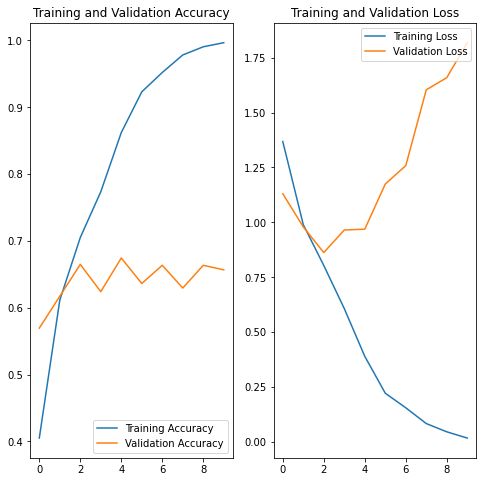

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Overfitting**




> in the above plots, the accuracy of the training increases linearly over time. Whereas, the validation accuracy stalls around 60% in the trainign process.

> The difference in training and validation accuracy is noticeable which is a sign of **overfitting**


> To prevent the overfiting in the training processs,	**3 separate approaches was taken to improve the accuracy of the model on the Test Dataset**,Itemized below


1.   Data Augumentation
2.   Addition of more dropout Layers
3.   Altering the multi-layer feed-forward NN at the end of the network 













**Data augmentation**


> **Data augumation** improves the accuaracy by simply geenerating additional training data from the existing examples by augumenting them using random transformations. Aslo, it exposes the model to more aspects of the data and generalize better. 

> Data augumnetation is implemented using the layers from tf.keras.layers.experimental.preprocessing, can be added to the model inform of other layer, and run on the GPU





In [82]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
  ]
)

visualization of the augumented example

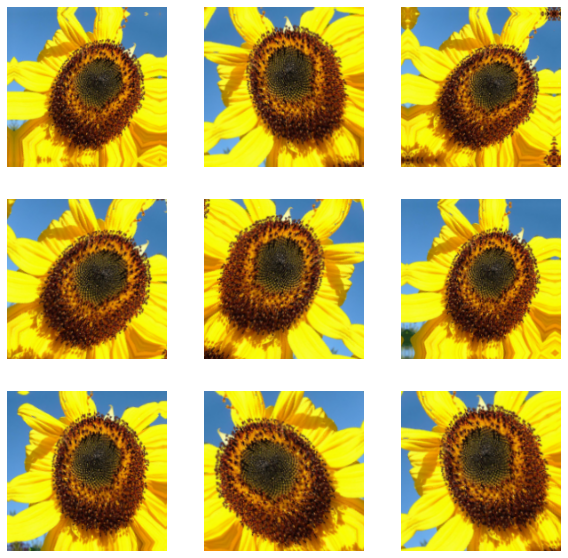

In [83]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Dropout**



>  **Dropout is used to reduced overfitting by introducing it to the network, a form of regularization.**

> When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

> Creating a new neural network using layers.Dropout, then train it using augmented images.







In [84]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compile and train the** **model**

In [86]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [87]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)       

In [88]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 103s 1s/step - loss: 1.5076 - accuracy: 0.3490 - val_loss: 1.0367 - val_accuracy: 0.5613
Epoch 2/15
92/92 [==============================] - 100s 1s/step - loss: 1.0368 - accuracy: 0.5992 - val_loss: 0.9971 - val_accuracy: 0.6362
Epoch 3/15
92/92 [==============================] - 100s 1s/step - loss: 0.8917 - accuracy: 0.6643 - val_loss: 0.8579 - val_accuracy: 0.6757
Epoch 4/15
92/92 [==============================] - 100s 1s/step - loss: 0.8613 - accuracy: 0.6566 - val_loss: 0.8473 - val_accuracy: 0.6785
Epoch 5/15
92/92 [==============================] - 100s 1s/step - loss: 0.7702 - accuracy: 0.6956 - val_loss: 0.9388 - val_accuracy: 0.6567
Epoch 6/15
92/92 [==============================] - 100s 1s/step - loss: 0.7391 - accuracy: 0.7327 - val_loss: 0.8370 - val_accuracy: 0.6757
Epoch 7/15
92/92 [==============================] - 100s 1s/step - loss: 0.7365 - accuracy: 0.7280 - val_loss: 0.9092 - val_accuracy: 0.6608
Epoch 8/15
92

**Visualize training** **results**

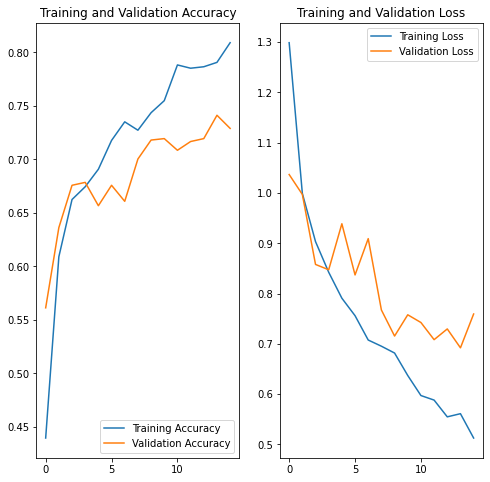

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


1.  **Why are Deep Learning models generally seen to outperform classical
Machine Learning Models in Supervised Learning for Computer Vision?**




>  Ability of Deep learing models to make use of the appearance of large, high-quality, publicly available labelled datasets, along with the empowerment of parallel GPU computing, which enabled the transition from CPU-based to GPU-based training thus allowing for signifcant acceleration in deep models’ training for computer vision. 



> Deep learning models are capable of creating new features by themselves while in classical machine learning approach, features need to be identified accurately by users.


> In deep learning, problems are solved on an end-to-end basis while for classical machine learning models, tasks are divided into small pieces and then received results are combined into one conclusion.


> Deep learning models usally learn by creating a more abstract representation of data as the network grows deeper, due to this the model automatically extracts features and yields higher accuracy results.


> Deep Learning models usually learn high level features from data. That is the distinctive part of Deep learning models. 


> Deep learning reduces the task of developing new feature extractor for every problems.








**In your mind, what techniques / model architectures are popular when it comes to Computer Vision?**



> The most popular architecture used for computer vision is Convolutional Neural Networks **(CNNs)**

 

> Fast **R-CNN**




> Faster **R-CNN**



> Histogram of Oriented Gradients **(HOG)**





> Region-based Convolutional Neural Networks **(R-CNN)**


> Region-based Fully Convolutional Network **(R-FCN)**




> Single Shot Detector **(SSD)**


> Spatial Pyramid Pooling **(SPP-net)**


> YOLO (You Only Look Once)

















